In [1]:
import json 
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from glob import glob 
os.chdir('../')

def load_df(log_dir):
    with open(log_dir, 'r') as f:
        data = f.readlines()
    df = pd.DataFrame(list(pd.Series(data).map(eval).values))    
    return df 

def load_log_data(class_name, version, result_dir,method):

    df = pd.DataFrame()
    for i,v in enumerate(version):
        log_dir = os.path.join(result_dir,class_name,method,v,'log.txt')
        
        temp_df = load_df(log_dir)
        temp_df['hue'] = v 
        
        df = pd.concat([df,temp_df])
    
    return df 

def plot_log(data,class_name, metrics:list, figsize:tuple = (10,7)):
    
    fig, axes = plt.subplots(len(metrics),1,figsize=figsize)
    
    for ax, metric in zip(axes, metrics):
        sns.lineplot(
            x = 'epoch',
            y = metric,
            data = data,
            hue = data['hue'],
            ax = ax 
        )
        
    fig.suptitle(class_name)
    plt.show()
    
def read_txt(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()    
    df = pd.DataFrame([eval(d) for d in data]) 
    return df 

In [220]:
version = ['DatasetFollowOfficial-sampling_ratio_0.1-anomaly_ratio_0.0-n_query_0']
result_dir = './results/MVTecAD/'
method = 'PatchCore'

log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

auroc_list = {}
df = pd.DataFrame()
for log_dir in log_dirs:
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    auroc = pd.DataFrame(data['test_metrics'][0]).query('index == "auroc"').values[0]
    auroc_list[class_name] = {'image_auroc':auroc[0], 'pixel_auroc':auroc[1]}
    temp_df = pd.DataFrame(auroc_list).T.reset_index().sort_values(by='index').reset_index(drop=True)
    
df = temp_df

In [158]:
image_auroc = '100 99.4 97.8 98.7 97.9 100 100 100 96.0 97.0 98.9 99.7 100 99.0 99.5'
pixel_auroc = '98.6 98.5 98.9 99.1 98.7 98.7 99.3 98.4 97.6 99.4 95.9 98.7 96.4 95.1 98.9'
paper = pd.DataFrame([image_auroc.split(' '),pixel_auroc.split(' ')]).T
paper.columns = ['image_auroc','pixel_auroc']
paper.index = temp_df['index']
paper= paper.reset_index()
paper['image_auroc'] = paper['image_auroc'].map(float)
paper['pixel_auroc'] = paper['pixel_auroc'].map(float)

In [160]:
df = pd.DataFrame(np.hstack([df.values,paper.values]))
df.drop(columns = 3 ,inplace=True)
df.columns = ['class','image_auroc','pixel_auroc','image_auroc','pixel_auroc']
df.index = df['class']
df = df.drop(columns='class')
df = pd.DataFrame(df.values,
             index = df.index,
             columns = [
                 ['Exp','Exp','Paper','Paper'],
                 ['Image_AUROC','Image_AUROC','Pixel_AUROC','Pixel_AUROC']
             ])

In [168]:
df['Paper'].mean()

Pixel_AUROC    98.926667
Pixel_AUROC    98.146667
dtype: float64

# 실험 2 : PatchCore - MVTecAD - NoisedAD 

In [2]:
version = ['noisedad-sampling_ratio_0.1-anomaly_ratio_0.*-n_query_0']
result_dir = './results/MVTecAD/'
method = 'PatchCore'

log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    auroc = pd.DataFrame(data['test_metrics'][0]).query('index == "auroc"').values[0]
    auroc_list[class_name] = {'image_auroc':auroc[0], 'pixel_auroc':auroc[1]}
    temp_df = pd.DataFrame(auroc_list).T.reset_index().sort_values(by='index').reset_index(drop=True)
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    
    df = pd.concat([df,temp_df])
    
    
    
df.reset_index(drop=True,inplace=True)
# df = df.sort_values(by=['index','anomaly_ratio']).reset_index(drop=True)
# df['sampling_method'] = 'identity'

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it's already defined

# Define a color palette that has as many colors as there are unique categories
palette = sns.color_palette("husl", df['category'].nunique())

fig, axes = plt.subplots(2, 1, figsize=(7, 7))

# Create the line plot on the first axes with the defined palette
sns.lineplot(
    x='anomaly_ratio',
    y='image_auroc',
    hue='category',
    data=df,
    ax=axes[0],
    palette=palette  # Use the predefined palette
)

# Set the x-ticks for the first axes
axes[0].set_xticks([0, 0.1, 0.2])

# Remove the original legend generated by Seaborn for the first axes
axes[0].get_legend().remove()

# Create the line plot on the second axes with the defined palette
sns.lineplot(
    x='anomaly_ratio',
    y='pixel_auroc',
    hue='category',
    data=df,
    ax=axes[1],
    palette=palette  # Use the same predefined palette
)

# Remove the original legend generated by Seaborn for the second axes
axes[1].get_legend().remove()

# Place the legend at the bottom of the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

# Adjust the layout to make room for the legend
plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.show()


KeyError: 'category'

# 실험 3 : SoftPatch - MVTecAD - NoisedAD 

In [374]:
version = ['noisedad-*-sampling_ratio_0.1-anomaly_ratio_0.*-n_query_0']
result_dir = './results/MVTecAD/'
method = 'PatchCore'

log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    auroc = pd.DataFrame(data['test_metrics'][0]).query('index == "auroc"').values[0]
    auroc_list[class_name] = {'image_auroc':auroc[0], 'pixel_auroc':auroc[1]}
    temp_df = pd.DataFrame(auroc_list).T.reset_index().sort_values(by='index').reset_index(drop=True)
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    temp_df['sampling_method'] = log_dir.split('/')[-3].split('-')[1]
    
    df = pd.concat([df,temp_df])
    
    
    
df.reset_index(drop=True,inplace=True)
df = df.sort_values(by=['index','anomaly_ratio']).reset_index(drop=True)
df = pd.concat([df, df1])

In [337]:
plot_df = df.groupby(['sampling_method','anomaly_ratio'])['image_auroc','pixel_auroc'].mean().reset_index()
plot_df

/tmp/ipykernel_26342/141420808.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_df = df.groupby(['sampling_method','anomaly_ratio'])['image_auroc','pixel_auroc'].mean().reset_index()


,sampling_method,anomaly_ratio,image_auroc,pixel_auroc
0,gaussian,0.0,0.950445,0.982137
1,gaussian,0.1,0.954637,0.976660
2,gaussian,0.2,0.950949,0.960118
3,identity,0.0,0.987204,0.983959
4,identity,0.1,0.981158,0.951718
5,identity,0.2,0.972746,0.938492
6,lof,0.0,0.981236,0.983117
7,lof,0.1,0.981069,0.982928
8,lof,0.2,0.980064,0.970853
9,nearest,0.0,0.961769,0.982165


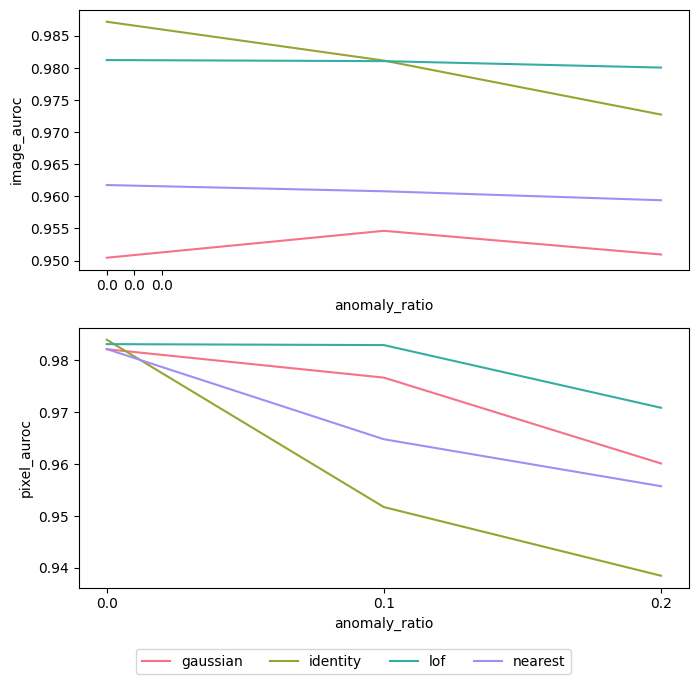

In [350]:
palette = sns.color_palette("husl", plot_df['sampling_method'].nunique())

fig, axes = plt.subplots(2, 1, figsize=(7, 7))

# Create the line plot on the first axes with the defined palette
sns.lineplot(
    x='anomaly_ratio',
    y='image_auroc',
    hue='sampling_method',
    data=plot_df,
    ax=axes[0],
    palette=palette  # Use the predefined palette
)

# Set the x-ticks for the first axes
axes[0].set_xticks([0, 0.1, 0.2])

# Remove the original legend generated by Seaborn for the first axes
axes[0].get_legend().remove()

# Create the line plot on the second axes with the defined palette
sns.lineplot(
    x='anomaly_ratio',
    y='pixel_auroc',
    hue='sampling_method',
    data=plot_df,
    ax=axes[1],
    palette=palette  # Use the predefined palette
)

# Remove the original legend generated by Seaborn for the second axes
axes[1].get_legend().remove()

# Place the legend at the bottom of the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.02))

# Adjust the layout to make room for the legend
plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.show()


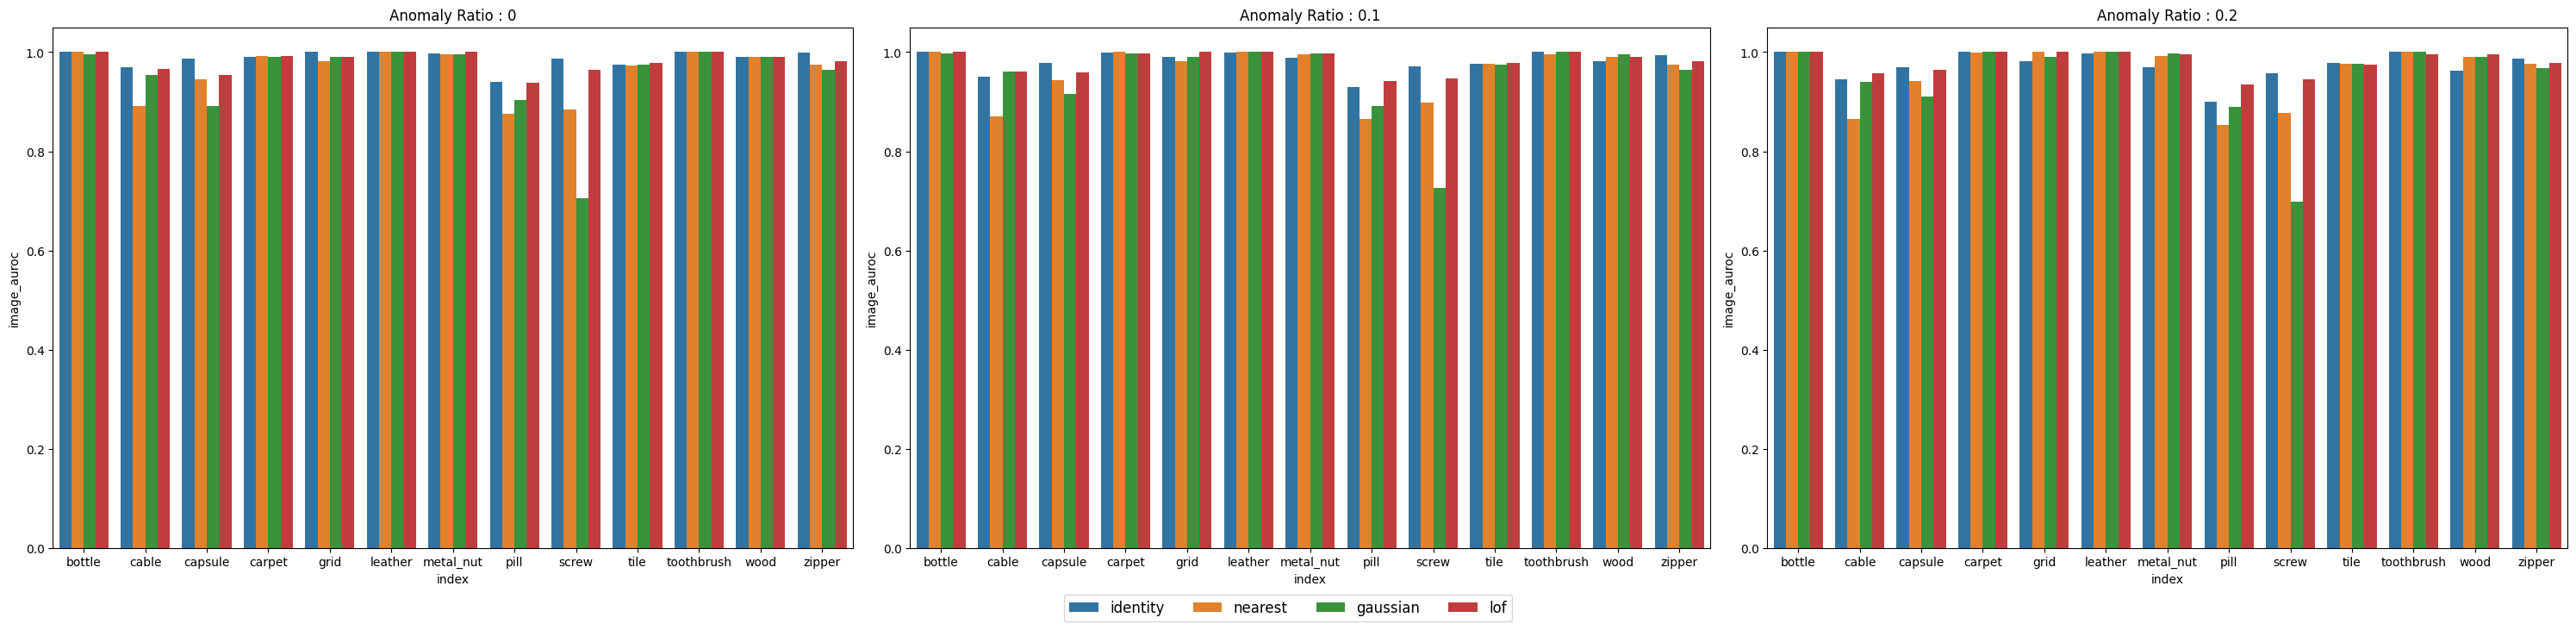

In [394]:
fig, axes = plt.subplots(1,3, figsize=(30,7))

for i, ratio in enumerate([0,0.1,0.2]):
    sns.barplot(
        data = df[df['anomaly_ratio'] == ratio],
        x = 'index',
        y = 'image_auroc',
        hue = 'sampling_method',
        hue_order = ['identity','nearest','gaussian','lof'],
        ax= axes[i]
    )

    handles, labels = axes[0].get_legend_handles_labels()
    axes[i].get_legend().remove()
    axes[i].set_title(f'Anomaly Ratio : {ratio}')
    
    if i == 0:        
        fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05), fontsize='large')
plt.tight_layout()

In [398]:
df[df['sampling_method'] == 'lof']

,index,image_auroc,pixel_auroc,anomaly_ratio,sampling_method
0,bottle,1.000000,0.987639,0.0,lof
3,bottle,1.000000,0.987695,0.1,lof
7,bottle,1.000000,0.989729,0.2,lof
9,cable,0.965517,0.982722,0.0,lof
12,cable,0.960489,0.983164,0.1,lof
16,cable,0.957256,0.982219,0.2,lof
18,capsule,0.954545,0.989122,0.0,lof
21,capsule,0.959157,0.989408,0.1,lof
25,capsule,0.964427,0.989717,0.2,lof
27,carpet,0.991342,0.993178,0.0,lof


# 실험 4 : Logical Anomaly에 대한 결과 확인 

In [401]:
version = ['DatasetFollowOfficial-sampling_ratio_0.1-anomaly_ratio_0.0-n_query_0']
result_dir = './results/MVTecLoco/'
method = 'PatchCore'

log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    auroc = pd.DataFrame(data['test_metrics'][0]).query('index == "auroc"').values[0]
    auroc_list[class_name] = {'image_auroc':auroc[0], 'pixel_auroc':auroc[1]}
    temp_df = pd.DataFrame(auroc_list).T.reset_index().sort_values(by='index').reset_index(drop=True)
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    temp_df['sampling_method'] = log_dir.split('/')[-3].split('-')[1]
    
    df = pd.concat([df,temp_df])
    
    
    
df.reset_index(drop=True,inplace=True)
df = df.sort_values(by=['index','anomaly_ratio']).reset_index(drop=True)

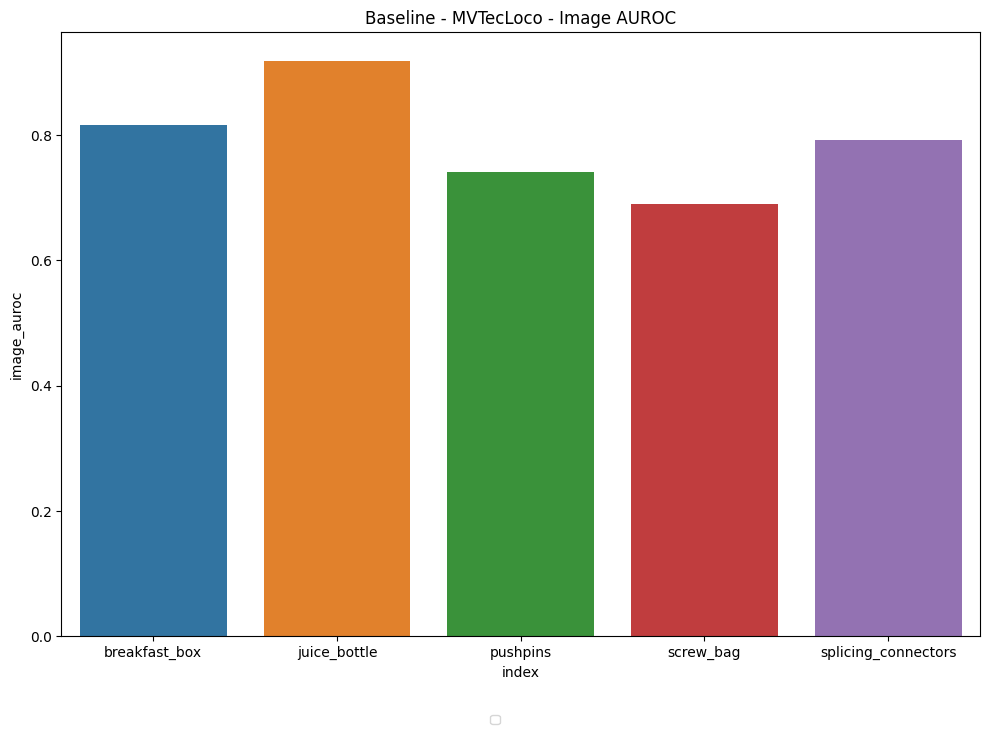

In [415]:
fig,ax = plt.subplots(1,1, figsize=(10,7))
sns.barplot(
    data = df,
    x = 'index',
    y = 'image_auroc',
    ax = ax 
)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05), fontsize='small')

plt.title('Baseline - MVTecLoco - Image AUROC')
plt.tight_layout()

## 4.2 Anomaly Ratio에 따른 성능 변화 확인 

In [417]:
version = ['noisedad-*-sampling_ratio_0.1-anomaly_ratio_0.*-n_query_0']
result_dir = './results/MVTecLoco/'
method = 'PatchCore'

log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    auroc = pd.DataFrame(data['test_metrics'][0]).query('index == "auroc"').values[0]
    auroc_list[class_name] = {'image_auroc':auroc[0], 'pixel_auroc':auroc[1]}
    temp_df = pd.DataFrame(auroc_list).T.reset_index().sort_values(by='index').reset_index(drop=True)
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    temp_df['sampling_method'] = log_dir.split('/')[-3].split('-')[1]
    
    df = pd.concat([df,temp_df])
    
    
    
df.reset_index(drop=True,inplace=True)
df = df.sort_values(by=['index','anomaly_ratio']).reset_index(drop=True)

In [424]:
plot_df = df.groupby(['sampling_method','anomaly_ratio'])['image_auroc','pixel_auroc'].mean().reset_index()
plot_df

/tmp/ipykernel_26342/141420808.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_df = df.groupby(['sampling_method','anomaly_ratio'])['image_auroc','pixel_auroc'].mean().reset_index()


,sampling_method,anomaly_ratio,image_auroc,pixel_auroc
0,gaussian,0.0,0.734708,0.887726
1,gaussian,0.1,0.730253,0.883831
2,gaussian,0.2,0.737515,0.889010
3,identity,0.0,0.790967,0.869607
4,identity,0.1,0.766550,0.842673
5,identity,0.2,0.751065,0.843337
6,lof,0.0,0.787996,0.868355
7,lof,0.1,0.773255,0.875399
8,lof,0.2,0.768179,0.858632
9,nearest,0.0,0.690940,0.890049


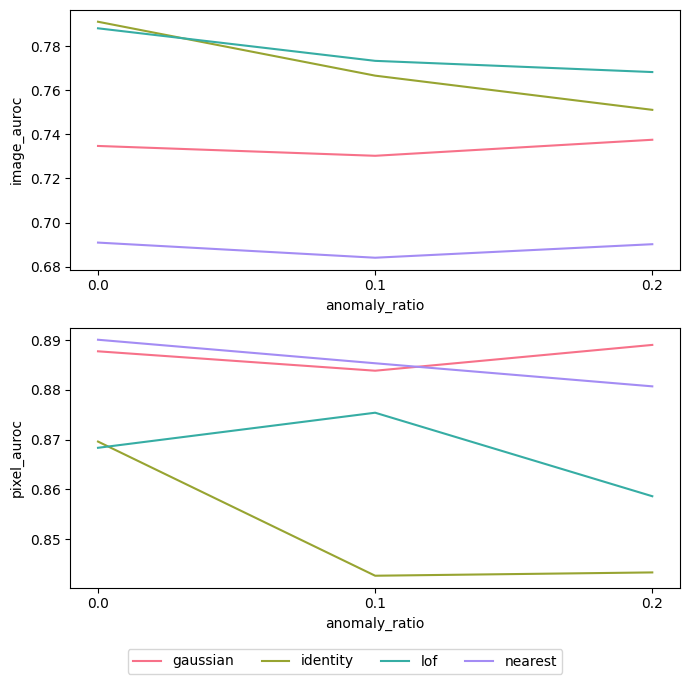

In [426]:
palette = sns.color_palette("husl", plot_df['sampling_method'].nunique())

fig, axes = plt.subplots(2, 1, figsize=(7, 7))

# Create the line plot on the first axes with the defined palette
sns.lineplot(
    x='anomaly_ratio',
    y='image_auroc',
    hue='sampling_method',
    data=plot_df,
    ax=axes[0],
    palette=palette  # Use the predefined palette
)

# Set the x-ticks for the first axes
axes[0].set_xticks([0, 0.1, 0.2])
axes[0].get_legend().remove()

# Create the line plot on the second axes with the defined palette
sns.lineplot(
    x='anomaly_ratio',
    y='pixel_auroc',
    hue='sampling_method',
    data=plot_df,
    ax=axes[1],
    palette=palette  # Use the predefined palette
)

# Remove the original legend generated by Seaborn for the second axes
axes[1].set_xticks([0, 0.1, 0.2])
axes[1].get_legend().remove()

# Place the legend at the bottom of the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.02))

# Adjust the layout to make room for the legend
plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.show()


In [439]:
# plot_df = df.groupby(['sampling_method','anomaly_ratio'])['image_auroc','pixel_auroc'].mean().reset_index()

df['index'].unique()

array(['breakfast_box', 'juice_bottle', 'pushpins', 'screw_bag',
       'splicing_connectors'], dtype=object)

In [ ]:
palette = sns.color_palette("husl", plot_df['sampling_method'].nunique())

fig, axes = plt.subplots(2, 1, figsize=(7, 7))

# Create the line plot on the first axes with the defined palette
sns.lineplot(
    x='anomaly_ratio',
    y='image_auroc',
    hue='sampling_method',
    data=plot_df,
    ax=axes[0],
    palette=palette  # Use the predefined palette
)

# Set the x-ticks for the first axes
axes[0].set_xticks([0, 0.1, 0.2])
axes[0].get_legend().remove()

# Create the line plot on the second axes with the defined palette
sns.lineplot(
    x='anomaly_ratio',
    y='pixel_auroc',
    hue='sampling_method',
    data=plot_df,
    ax=axes[1],
    palette=palette  # Use the predefined palette
)

# Remove the original legend generated by Seaborn for the second axes
axes[1].set_xticks([0, 0.1, 0.2])
axes[1].get_legend().remove()

# Place the legend at the bottom of the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.02))

# Adjust the layout to make room for the legend
plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.show()


## 4.3 Anomalies type에 따라 봐보자 

In [201]:
version = ['noisedad-*-sampling_ratio_0.1-anomaly_ratio_0.*-n_query_0']
result_dir = './results/MVTecLoco/'
method = 'PatchCore'

log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    auroc = pd.DataFrame(data['test_metrics'][0]).query('index == "auroc"').values[0]
    data = pd.DataFrame(data['test_metrics'][0]).iloc[3,:].reset_index()
    data['structural_anomalies'] = data['loco_auroc'].apply(lambda x : x['structural_anomalies'])
    data['logical_anomalies'] = data['loco_auroc'].apply(lambda x : x['logical_anomalies'])
    data.drop(columns = 'loco_auroc',inplace=True)
    temp_df = data 
    
    temp_df['class'] = class_name 
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    temp_df['sampling_method'] = log_dir.split('/')[-3].split('-')[1]
    
    df = pd.concat([df,temp_df])

In [202]:
df = df.melt(['index','class','anomaly_ratio','sampling_method'])
# sampling method identity,랑 lof만 남기기 
df = df[(df['sampling_method'] =='identity') | (df['sampling_method'] =='lof')].reset_index(drop=True)
# 이름 바꾸기 
df.loc[df['sampling_method']=='identity','sampling_method'] = 'PatchCore'
df.loc[df['sampling_method']=='lof','sampling_method'] = 'SoftPatch'

In [210]:
plot_df = df.groupby(['variable','anomaly_ratio','sampling_method','index'])['value'].mean().reset_index()
# plot_df = plot_df[plot_df['index'] == 'img_level'].reset_index(drop=True)

In [214]:
result = plot_df.pivot_table(index=['sampling_method','index'],columns=['variable','anomaly_ratio'],values='value')
result['temp'] = 0 

In [215]:
result

variable                  logical_anomalies                      \
anomaly_ratio                           0.0       0.1       0.2   
sampling_method index                                             
PatchCore       img_level          0.754385  0.725025  0.697596   
                pix_level          0.752638  0.700327  0.684109   
SoftPatch       img_level          0.757314  0.735424  0.729154   
                pix_level          0.750863  0.747327  0.732116   

variable                  structural_anomalies                     temp  
anomaly_ratio                              0.0       0.1       0.2       
sampling_method index                                                    
PatchCore       img_level             0.851070  0.831918  0.830172    0  
                pix_level             0.975167  0.969957  0.965950    0  
SoftPatch       img_level             0.839335  0.835632  0.831068    0  
                pix_level             0.973919  0.972733  0.971833    0

In [191]:
result_df = plot_df.pivot_table(index=['sampling_method'],columns=['variable','anomaly_ratio'],values='value')
logi_df = result_df['logical_anomalies']
logi_df['편차'] = result_df['logical_anomalies'][0.0] - result_df['logical_anomalies'][0.2]


st_df = result_df['structural_anomalies']
st_df['편차'] = result_df['structural_anomalies'][0.0] - result_df['structural_anomalies'][0.2]


# 각 데이터프레임에 MultiIndex 설정
logi_df.columns = pd.MultiIndex.from_product([['logical anomalies'], ['0.0','0.1','0.2', '편차']])
logi_df.columns.names = ['variable','anomaly_ratio']

st_df.columns = pd.MultiIndex.from_product([['structural_anomalies'], ['0.0','0.1','0.2', '편차']])
st_df.columns.names = ['variable','anomaly_ratio']
result_df = pd.concat([st_df,logi_df],axis=1)

<ipython-input-191-22231bdba0ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logi_df['편차'] = result_df['logical_anomalies'][0.0] - result_df['logical_anomalies'][0.2]
<ipython-input-191-22231bdba0ec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_df['편차'] = result_df['structural_anomalies'][0.0] - result_df['structural_anomalies'][0.2]


In [192]:
result_df['temp'] = 0 

In [196]:
result_df

variable        structural_anomalies                                \
anomaly_ratio                    0.0       0.1       0.2        편차   
sampling_method                                                      
PatchCore                   0.851070  0.831918  0.830172  0.020898   
SoftPatch                   0.839335  0.835632  0.831068  0.008267   

variable        logical anomalies                               temp  
anomaly_ratio                 0.0       0.1       0.2        편차       
sampling_method                                                       
PatchCore                0.754385  0.725025  0.697596  0.056789    0  
SoftPatch                0.757314  0.735424  0.729154  0.028160    0

In [199]:
result_df[['logical anomalies']].T

sampling_method                  PatchCore  SoftPatch
variable          anomaly_ratio                      
logical anomalies 0.0             0.754385   0.757314
                  0.1             0.725025   0.735424
                  0.2             0.697596   0.729154
                  편차              0.056789   0.028160

### Anomalies type - sampling method 

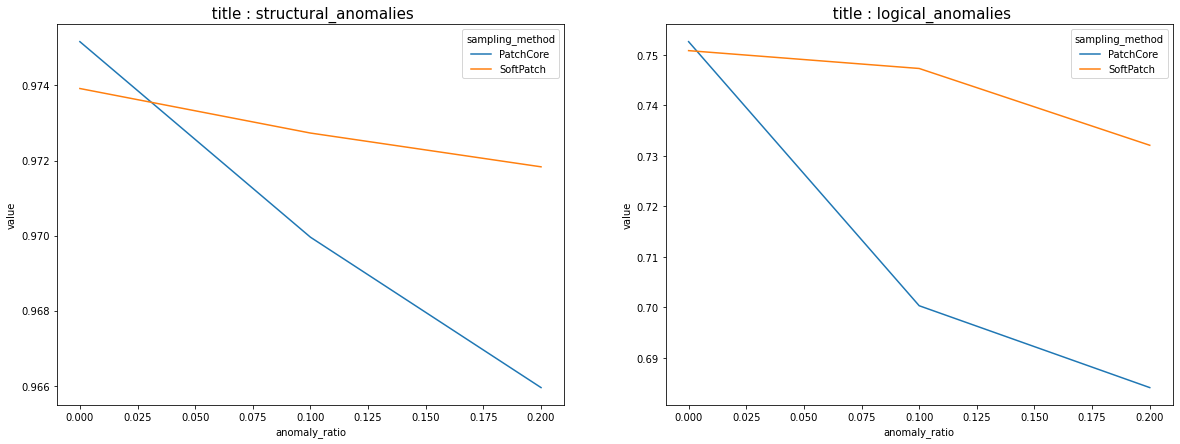

In [218]:
plot_df = df.groupby(['variable','sampling_method','anomaly_ratio','index'])['value'].mean().reset_index()
plot_df = plot_df[plot_df['index'] == 'pix_level'].reset_index(drop=True)

fig,axes = plt.subplots(1,2, figsize=(20,7))

for i, a_type in enumerate(['structural_anomalies','logical_anomalies']):
    sns.lineplot(
        x = 'anomaly_ratio',
        y = 'value',
        hue = 'sampling_method',
        data = plot_df[(plot_df['variable'] == a_type)],
        ax = axes[i]
    )   
    
    axes[i].set_title(f" title : {a_type}",size=15)

plt.show()


### Anomalies type - class type - sampling method 

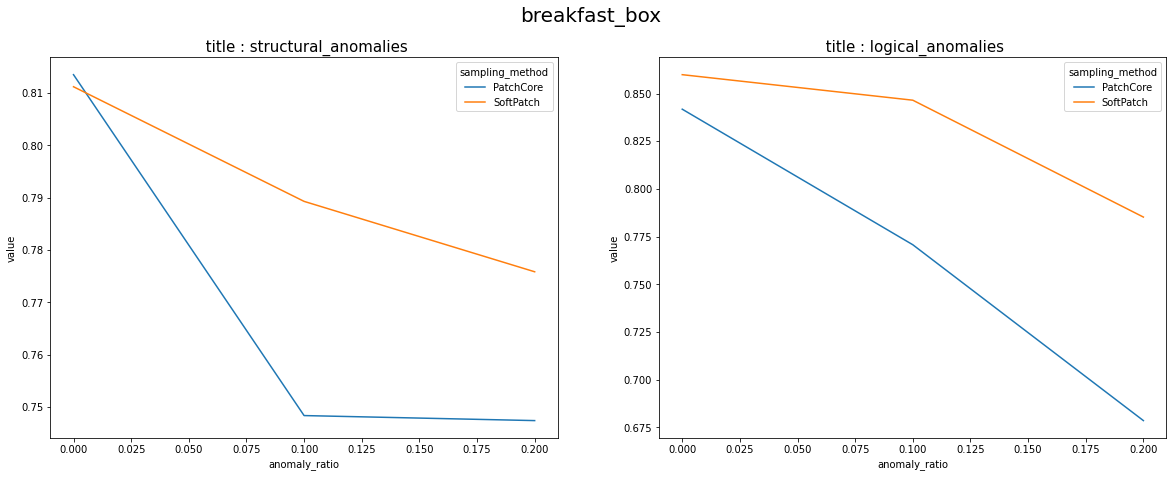

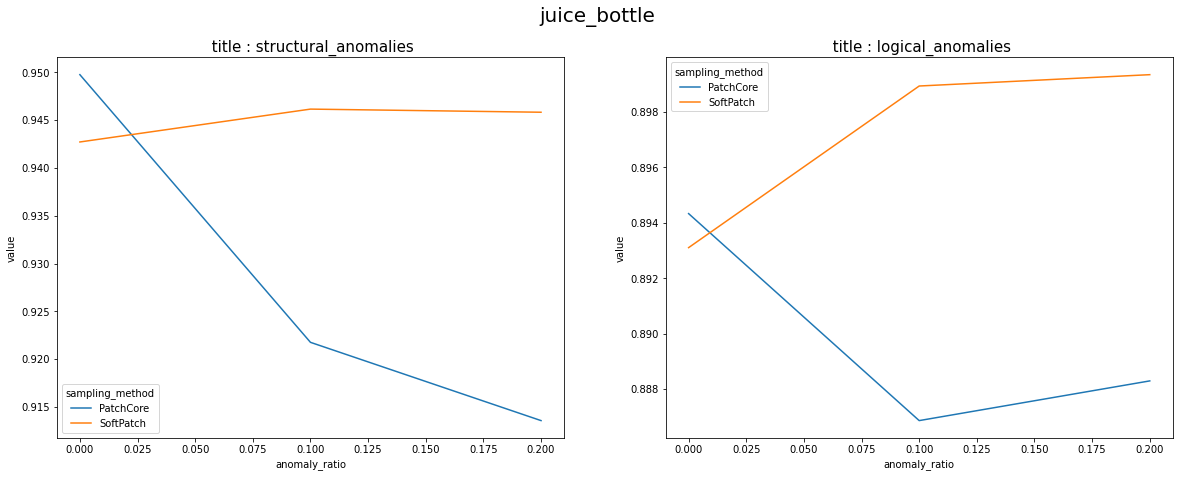

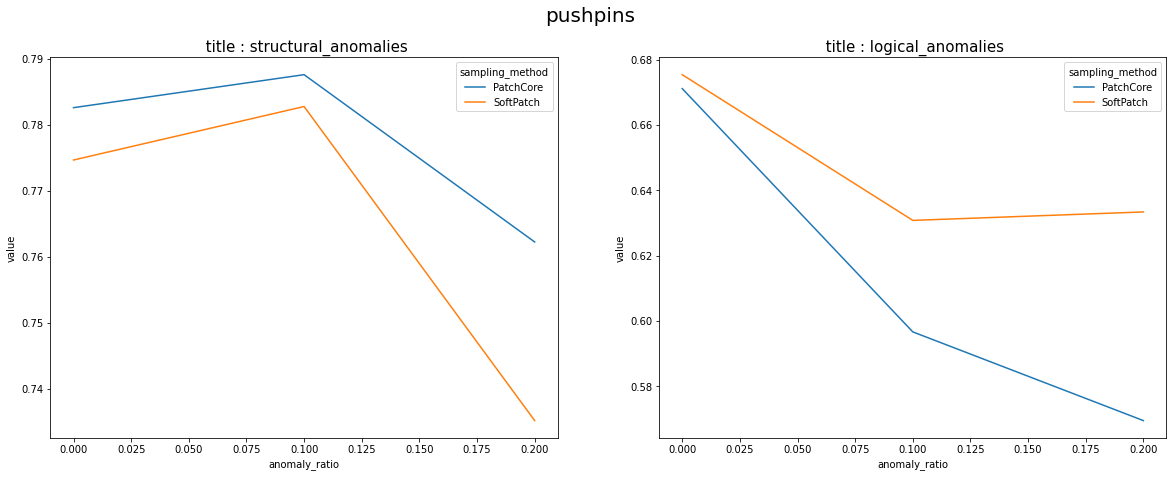

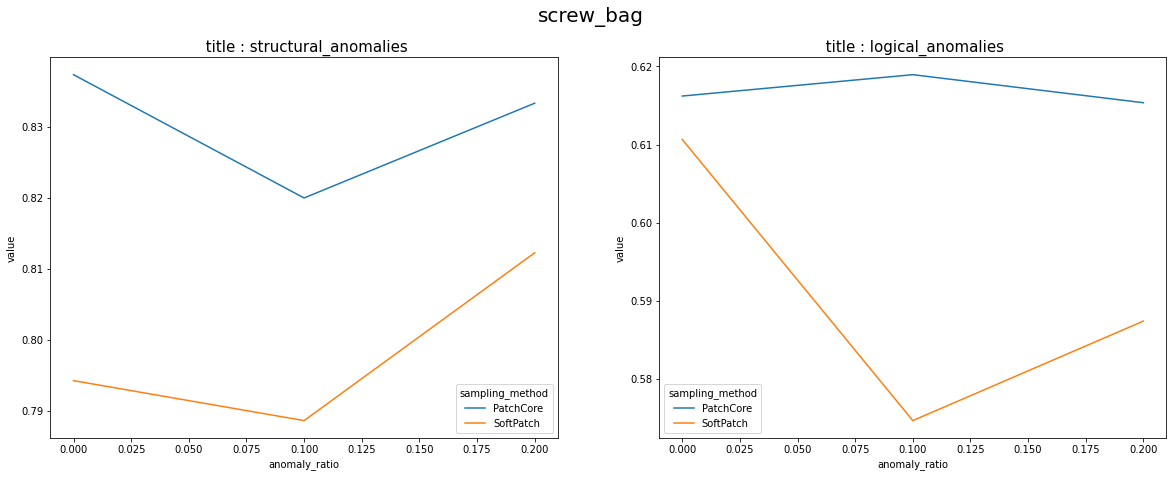

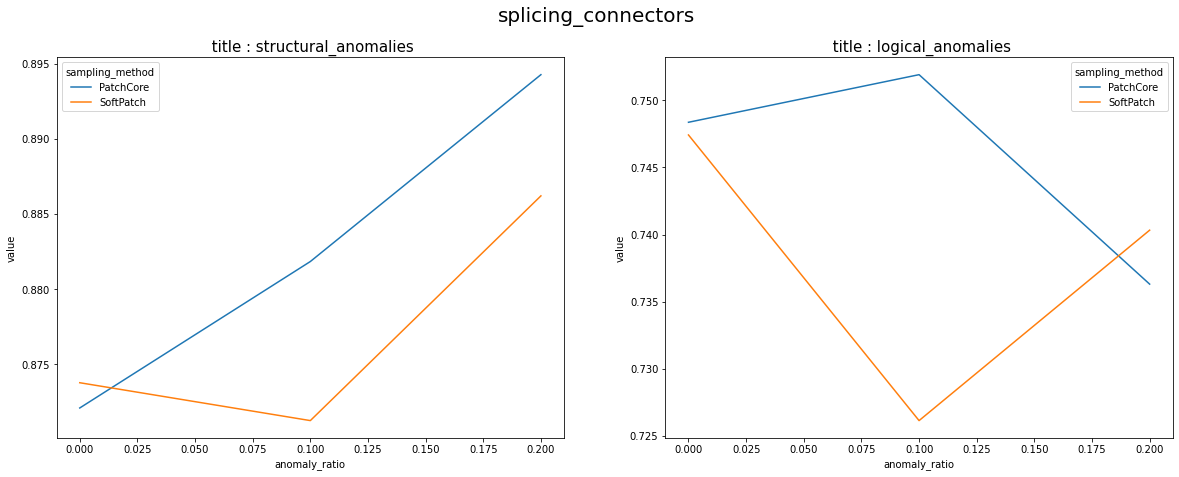

In [47]:
plot_df = df.groupby(['variable','sampling_method','anomaly_ratio','index','class'])['value'].mean().reset_index()
plot_df = plot_df[plot_df['index'] == 'img_level'].reset_index(drop=True)
for class_name in plot_df['class'].unique():
    fig,axes = plt.subplots(1,2, figsize=(20,7))

    for i, a_type in enumerate(['structural_anomalies','logical_anomalies']):
        sns.lineplot(
            x = 'anomaly_ratio',
            y = 'value',
            hue = 'sampling_method',
            data = plot_df[(plot_df['variable'] == a_type) & (plot_df['class']==class_name)],
            ax = axes[i]
        )   
        
        axes[i].set_title(f" title : {a_type}",size=15)
    fig.suptitle(class_name,size=20)
    
    plt.show()


## 4.4 Confusion Matrix를 봐볼까..? 

In [2]:
version = ['noisedad-*-sampling_ratio_0.1-anomaly_ratio_0.*-n_query_0']
result_dir = './results/MVTecLoco/'
method = 'PatchCore'

log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    auroc = pd.DataFrame(data['test_metrics'][0]).query('index == "auroc"').values[0]
    data = pd.DataFrame(data['test_metrics'][0])
    break 